In [158]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import metrics

# pd.options.mode.chained_assignment = None  # default='warn'

<h2>Getting stock data</h2>

In [159]:
def make_stock_df(symbol):
    tickerData = yf.Ticker(symbol)
    #get the historical prices for this ticker
    tickerDf = tickerData.history(period='1d', start='2010-1-1')
    dow = tickerDf.index.day_of_week
    data = tickerDf[["Close", "Volume"]]
    data.insert(1, 'Date_Week', dow)
    return data

In [160]:
def get_yahoo_stock_data(symbol, columns=None, dfrom='2020-1-1'):
    tickerData = yf.Ticker(symbol)
    tickerDf = tickerData.history(period='1d', start=dfrom)
    tickerDf["Date_Week"] = tickerDf.index.day_of_week
    targetDf = tickerDf if columns is None else tickerDf[columns]
    return targetDf

In [370]:
from math import nan


def gen_features(data):
    # create a percentage change feature
    data['pct_change'] = data.Close.pct_change()

    # 1 day before features
    data['1d_before_close'] = 0
    data['1d_before_volume'] = 0    

    # 2 days before features
    data['2d_before_close'] = 0
    data['2d_before_volume'] = 0

    #data['1d_before_close'][1:] = data['Close'][:-1]   # With warning: A value is trying to be set on a copy of a slice from a DataFrame

    #data['1d_before_close'][1:] = data['Close'][:-1]
    data['1d_before_close'] = data['Close'].copy().shift(periods=1)
    #pd_1d_before_close = data['1d_before_close'].copy()
    #pd_1d_before_close[1:] = data['Close'][:-1]
    #data['1d_before_close'] = pd_1d_before_close
    
    #data['1d_before_volume'][1:] = data['Volume'][:-1]
    pd_1d_before_volume = data['1d_before_volume'].copy()
    pd_1d_before_volume[1:] = data['Volume'][:-1]
    data['1d_before_volume'] = pd_1d_before_volume

    print(data['Close'][2:])

    pd_2d_before_close = data['2d_before_close'].copy()
    pd_2d_before_close[2:] = data['Close'][:-2]
    data['2d_before_close'] = pd_2d_before_close

    #data['2d_before_volume'][2:] = data['Volume'][:-2]
    pd_2d_before_volume = data['2d_before_volume'].copy()
    pd_2d_before_volume[2:] = data['Volume'][:-2]
    data['2d_before_volume'] = pd_2d_before_volume


    data['f_price_change'] = data['1d_before_close'] - data['2d_before_close']

    data['f_volume_change'] = data['1d_before_volume'] - data['2d_before_volume']

    data['f_sign'] = np.sign(data['f_price_change'] * data['f_volume_change'])

    data['f_date_week'] = data['Date_Week']

    data['f_volume_noise'] = data['1d_before_volume'] * data['2d_before_volume']
    data['f_price_noise'] = data['1d_before_close'] * data['2d_before_close'] * data['f_sign']

    # scale data
    #scaler = StandardScaler()
    #data['f_price_change'] = scaler.fit_transform(np.array(data['f_price_change']).reshape(-1,1))    
    #data['f_volume_change'] = scaler.fit_transform(np.array(data['f_volume_change']).reshape(-1,1))   
    #data['f_volume_noise'] = scaler.fit_transform(np.array(data['f_volume_noise']).reshape(-1,1))   
    #data['f_price_noise'] = scaler.fit_transform(np.array(data['f_price_noise']).reshape(-1,1))
    
    #feature_pd = data.filter(regex='pct_change|Close|1d_*|2d_*|f_price_change|f_volume_change|f_sign|f_date_week|f_volume_noise|f_price_noise')[:-2]         # first 2 record is missing 1d & 2d close and volume
    feature_pd = data.filter(regex='pct_change|Close|1d_*|2d_*|f_price_change|f_volume_change|f_sign|f_date_week|f_volume_noise|f_price_noise')
    
    feature_pd.insert(0, 'pct_change', feature_pd.pop('pct_change'))
    return feature_pd


In [354]:
# ["Date_Week", "Open", "High", "Low", "Close", "Volume"]
TSM_df = get_yahoo_stock_data("TSLA", columns=None, dfrom='2010-1-1')
TSM_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date_Week
Date,,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0,0.0,1
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0,0.0,2
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0,0.0,3
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0,0.0,4
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0,0.0,1
...,...,...,...,...,...,...,...,...
2022-10-06 00:00:00-04:00,239.440002,244.580002,235.350006,238.130005,69298400,0,0.0,3
2022-10-07 00:00:00-04:00,233.940002,234.570007,222.020004,223.070007,83592300,0,0.0,4
2022-10-10 00:00:00-04:00,223.929993,226.990005,218.360001,222.960007,67925000,0,0.0,0


In [371]:
train_df = gen_features(TSM_df)
train_df

Date
2010-07-01 00:00:00-04:00      1.464000
2010-07-02 00:00:00-04:00      1.280000
2010-07-06 00:00:00-04:00      1.074000
2010-07-07 00:00:00-04:00      1.053333
2010-07-08 00:00:00-04:00      1.164000
                                ...    
2022-10-06 00:00:00-04:00    238.130005
2022-10-07 00:00:00-04:00    223.070007
2022-10-10 00:00:00-04:00    222.960007
2022-10-11 00:00:00-04:00    216.500000
2022-10-12 00:00:00-04:00    217.240005
Name: Close, Length: 3093, dtype: float64


,pct_change,Close,1d_before_close,1d_before_volume,2d_before_close,2d_before_volume,f_price_change,f_volume_change,f_sign,f_date_week,f_volume_noise,f_price_noise
Date,,,,,,,,,,,,
2010-06-29 00:00:00-04:00,NaN,1.592667,NaN,0,0.000000,0,NaN,0,NaN,1,0,NaN
2010-06-30 00:00:00-04:00,-0.002511,1.588667,NaN,281494500,0.000000,0,NaN,281494500,NaN,2,0,NaN
2010-07-01 00:00:00-04:00,-0.078473,1.464000,1.464000,257806500,1.592667,281494500,-0.128667,-23688000,1.0,3,72571111814250000,2.331664
2010-07-02 00:00:00-04:00,-0.125683,1.280000,1.280000,123282000,1.588667,257806500,-0.308667,-134524500,1.0,4,31782900933000000,2.033494
2010-07-06 00:00:00-04:00,-0.160937,1.074000,1.074000,77097000,1.464000,123282000,-0.390000,-46185000,1.0,1,9504672354000000,1.572336
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-06 00:00:00-04:00,-0.011129,238.130005,238.130005,86982700,249.440002,109578500,-11.309998,-22595800,1.0,3,9531433791950000,59399.148999
2022-10-07 00:00:00-04:00,-0.063243,223.070007,223.070007,69298400,240.809998,86982700,-17.739990,-17684300,1.0,4,6027761937680000,53717.487919
2022-10-10 00:00:00-04:00,-0.000493,222.960007,222.960007,83592300,238.130005,69298400,-15.169998,14293900,-1.0,0,5792812642320000,-53093.467487


<AxesSubplot:xlabel='Date'>

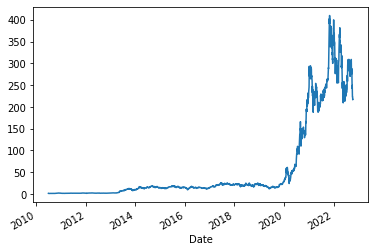

In [292]:
#TSM_df.regress_y.cumsum().plot()
TSM_df.Close.plot()

<H2>Train Data</H2>

In [293]:
train_df = gen_features(TSM_df)
train_df

,regress_y,Close,f_price_change,f_volume_change,f_sign,f_date_week,f_volume_noise,f_price_noise
Date,,,,,,,,
2010-07-01 00:00:00-04:00,-0.078473,1.464000,-0.004000,-23688000,1.0,3,72571111814250000,2.530218
2010-07-02 00:00:00-04:00,-0.125683,1.280000,-0.124667,-134524500,1.0,4,31782900933000000,2.325809
2010-07-06 00:00:00-04:00,-0.160937,1.074000,-0.184000,-46185000,1.0,1,9504672354000000,1.873920
2010-07-07 00:00:00-04:00,-0.019243,1.053333,-0.206000,25906500,-1.0,2,7941260839500000,-1.374720
2010-07-08 00:00:00-04:00,0.105064,1.164000,-0.020667,822000,-1.0,3,10694389889250000,-1.131280
...,...,...,...,...,...,...,...,...
2022-10-06 00:00:00-04:00,-0.011129,238.130005,-8.630005,-22595800,1.0,3,9531433791950000,60067.646379
2022-10-07 00:00:00-04:00,-0.063243,223.070007,-2.679993,-17684300,1.0,4,6027761937680000,57344.085894
2022-10-10 00:00:00-04:00,-0.000493,222.960007,-15.059998,14293900,-1.0,0,5792812642320000,-53119.661933


In [302]:
feature_np = train_df.values
train_x = feature_np[:, 1:]
train_y_regress = feature_np[:, 0]
train_y_classification = np.where(train_y_regress > 0, 1, 0)
train_x[:5], train_y_regress[:5], train_y_classification[:5]

(array([[ 1.46399999e+00, -3.99994850e-03, -2.36880000e+07,
          1.00000000e+00,  3.00000000e+00,  7.25711118e+16,
          2.53021753e+00],
        [ 1.27999997e+00, -1.24667048e-01, -1.34524500e+08,
          1.00000000e+00,  4.00000000e+00,  3.17829009e+16,
          2.32580852e+00],
        [ 1.07400000e+00, -1.84000015e-01, -4.61850000e+07,
          1.00000000e+00,  1.00000000e+00,  9.50467235e+15,
          1.87391994e+00],
        [ 1.05333304e+00, -2.05999970e-01,  2.59065000e+07,
         -1.00000000e+00,  2.00000000e+00,  7.94126084e+15,
         -1.37471997e+00],
        [ 1.16400003e+00, -2.06669569e-02,  8.22000000e+05,
         -1.00000000e+00,  3.00000000e+00,  1.06943899e+16,
         -1.13127969e+00]]),
 array([-0.07847274, -0.12568307, -0.16093748, -0.01924298,  0.10506363]),
 array([0, 0, 0, 0, 1]))

<H2>Test Data</H2>

In [295]:
SONY_df = get_yahoo_stock_data("GOOG", columns=None, dfrom='2010-1-1')
SONY_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date_Week
Date,,,,,,,,
2010-01-04 00:00:00-05:00,15.615220,15.678981,15.547723,15.610239,78541293,0,0.0,0
2010-01-05 00:00:00-05:00,15.620949,15.637387,15.480475,15.541497,120638494,0,0.0,1
2010-01-06 00:00:00-05:00,15.588072,15.588072,15.102393,15.149715,159744526,0,0.0,2
2010-01-07 00:00:00-05:00,15.178109,15.193053,14.760922,14.797037,257533695,0,0.0,3
2010-01-08 00:00:00-05:00,14.744733,15.024933,14.672753,14.994298,189680313,0,0.0,4
...,...,...,...,...,...,...,...,...
2022-10-06 00:00:00-04:00,101.500000,103.730003,101.500000,102.239998,17156200,0,0.0,3
2022-10-07 00:00:00-04:00,100.650002,101.419998,99.209999,99.570000,24232300,0,0.0,4
2022-10-10 00:00:00-04:00,99.849998,99.989998,97.870003,98.709999,16529900,0,0.0,0


In [296]:
test_df = gen_features(SONY_df)
test_df

,regress_y,Close,f_price_change,f_volume_change,f_sign,f_date_week,f_volume_noise,f_price_noise
Date,,,,,,,,
2010-01-06 00:00:00-05:00,-0.025209,15.149715,-0.068742,42097201,-1.0,2,9475103304332742,-242.606487
2010-01-07 00:00:00-05:00,-0.023280,14.797037,-0.391782,39106032,-1.0,3,19271339041383844,-235.449260
2010-01-08 00:00:00-05:00,0.013331,14.994298,-0.352678,97789169,-1.0,4,41139598036803570,-224.170902
2010-01-11 00:00:00-05:00,-0.001512,14.971633,0.197261,-67853382,-1.0,0,48849071875646535,-221.871184
2010-01-12 00:00:00-05:00,-0.017684,14.706875,-0.022665,99917116,-1.0,1,54930930976715277,-224.489126
...,...,...,...,...,...,...,...,...
2022-10-06 00:00:00-04:00,0.000196,102.239998,-0.190002,-4105400,1.0,3,417193417950000,10468.350699
2022-10-07 00:00:00-04:00,-0.026115,99.570000,0.019997,-1319300,-1.0,4,316969373100000,-10450.972706
2022-10-10 00:00:00-04:00,-0.008637,98.709999,-2.669998,7076100,-1.0,0,415734185260000,-10180.036556


In [303]:
feature_np = test_df.values
test_x = feature_np[:, 1:]
test_y_regress = feature_np[:, 0]
test_y_classification = np.where(test_y_regress > 0, 1, 0)
test_x[:5], test_y_regress[:5], test_y_classification[:5]

(array([[ 1.51497154e+01, -6.87417984e-02,  4.20972010e+07,
         -1.00000000e+00,  2.00000000e+00,  9.47510330e+15,
         -2.42606487e+02],
        [ 1.47970371e+01, -3.91781807e-01,  3.91060320e+07,
         -1.00000000e+00,  3.00000000e+00,  1.92713390e+16,
         -2.35449260e+02],
        [ 1.49942980e+01, -3.52678299e-01,  9.77891690e+07,
         -1.00000000e+00,  4.00000000e+00,  4.11395980e+16,
         -2.24170902e+02],
        [ 1.49716330e+01,  1.97260857e-01, -6.78533820e+07,
         -1.00000000e+00,  0.00000000e+00,  4.88490719e+16,
         -2.21871184e+02],
        [ 1.47068748e+01, -2.26650238e-02,  9.99171160e+07,
         -1.00000000e+00,  1.00000000e+00,  5.49309310e+16,
         -2.24489126e+02]]),
 array([-0.02520876, -0.02327953,  0.01333111, -0.00151158, -0.01768398]),
 array([0, 0, 1, 0, 0]))

In [304]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

def regress_process(estimator, train_x, train_y_regress, test_x, test_y_regress):
    estimator.fit(train_x, train_y_regress)
    print(train_y_regress)
    test_y_predict_regress = estimator.predict(test_x)
    print(test_y_regress)
    print(test_y_predict_regress)
    plt.plot(test_y_regress.cumsum())
    plt.plot(test_y_predict_regress)


    scores = cross_val_score(estimator, train_x, train_y_regress, cv=10, scoring="neg_mean_squared_error")
    mean_sc = np.mean(np.sqrt(-scores))
    print('RMSE: ' + str(mean_sc))

[-0.07847274 -0.12568307 -0.16093748 ... -0.00049312 -0.02897384
  0.00341804]
[-0.07847274 -0.12568307 -0.16093748 ... -0.00049312 -0.02897384
  0.00341804]
[0.00286719 0.00275102 0.00215085 ... 0.00349951 0.00192693 0.00341356]
RMSE: 0.03509977321480176


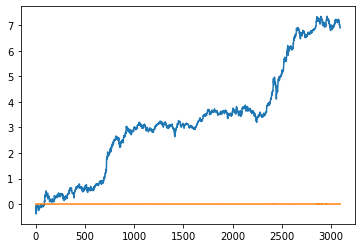

In [306]:
estimator = LinearRegression()
regress_process(estimator, train_x, train_y_regress, train_x, train_y_regress)

[-0.07847274 -0.12568307 -0.16093748 ... -0.00049312 -0.02897384
  0.00341804]
[-0.02520876 -0.02327953  0.01333111 ... -0.00863715 -0.00668621
  0.00254972]
[0.00188442 0.00201753 0.00208265 ... 0.00234165 0.0020701  0.0023386 ]
RMSE: 0.03509977321480176


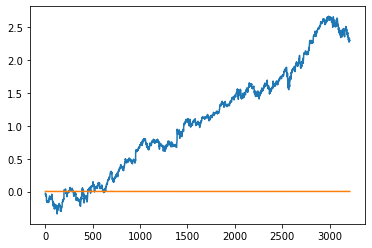

In [305]:
estimator = LinearRegression()
regress_process(estimator, train_x, train_y_regress, test_x, test_y_regress)

[-0.07847274 -0.12568307 -0.16093748 ... -0.00049312 -0.02897384
  0.00341804]
[-0.02520876 -0.02327953  0.01333111 ... -0.00863715 -0.00668621
  0.00254972]
[0.00361283 0.00361283 0.00361283 ... 0.00112488 0.00816561 0.00816561]
RMSE: 0.035798354296104715


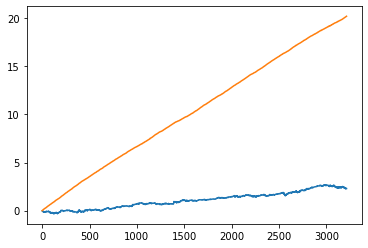

In [270]:
from sklearn.ensemble import AdaBoostRegressor

estimator3 = AdaBoostRegressor(n_estimators=100)
regress_process(estimator3, train_x, train_y_regress, test_x, test_y_regress)

[ 0.87889463 -0.28533208  0.62182637 ...  0.3679681   0.9742988
  0.37812105]
RMSE: 1.8227239944861775


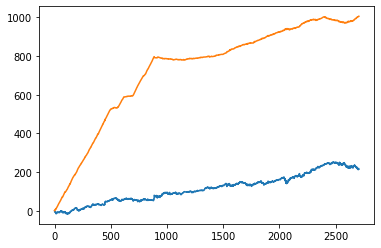

In [201]:
from sklearn.ensemble import RandomForestRegressor

estimator4 = RandomForestRegressor(n_estimators=100)
regress_process(estimator4, train_x, train_y_regress, test_x, test_y_regress)